<a href="https://colab.research.google.com/github/AIDA-DA/aida-project-image-scene/blob/main/notebooks/Project_Image_Scene_Classification_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://storage.googleapis.com/kaggle-datasets-images/130081/310927/007f156e945286c81911147dd952ad22/dataset-cover.jpg?t=2019-03-02-09-45-36" width="100%">
<center><h1>AIDA Final Project</h1></center>
<center><p>Image Scene Classification</p></center>

We will use [this](https://www.kaggle.com/puneet6060/intel-image-classification) Kaggle dataset which contains 25k images of the 6 categories. Our goal is to develop an algorithm which can distinguish the different image categories. I this approach I will use Tensorflow Keras together with pretained models provided by the framework.

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'2.3.0'

In [5]:
!nvidia-smi

Thu Dec  3 18:47:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download & Prepare Dataset

In [6]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Download the artist dataset using the Kaggle API. In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine. Upload `kaggle.json` into Google Colab Files

In [7]:
os.environ["KAGGLE_CONFIG_DIR"] = "/content"
os.chmod("/content", 600)
os.chmod("/content/kaggle.json", 600)

or set username and API-Key as enviroment variables

```
os.environ['KAGGLE_USERNAME'] = 'paulbauriegel'
os.environ['KAGGLE_KEY'] = '...'
```

Authenticate and Download Dataset from Kaggle

In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [9]:
api.dataset_download_files('puneet6060/intel-image-classification', unzip=True)

In [10]:
images_dir = '/content/seg_train/seg_train'
class_names = os.listdir(images_dir)
n_classes = len(class_names)

### Create Image Classification Model

Import some Keras functionality

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [12]:
IMG_SIZE = 150
batch_size = 128

#### Transfer learning and fine-tuning - different approaches

With Keras we can use the weights from a pre-trained model. These weights have been trained on a large-scale image-classification task called *imagenet*. We can proceed by different approaches:

1. **Feature-Extraction**: Use the pretrained model for Feature-Extraction network and set some classification layers ontop. Use `include_top=False` and freeze the layers of the base model

2. **Fine-Tuning**: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model.

    2.1. V1: Un-freeze the top layers of the model - approach used in the [Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning) and by the [DeepArtist](https://www.kaggle.com/supratimhaldar/deepartist-identify-artist-from-art) implementation. First we train the hole model including the new classification layers

    2.2. V2: Opposite Approach - train the hole model for 10 epochs and then train the top 50 layers for 50 epochs

    2.3. V3: Train all layers - for 60 epochs

In [13]:
# Train the model - all layers
def trainfull_ResNet50(train_gen, val_gen, class_weights=None, 
                       full_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  model = ResNet50(include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                        classes=n_classes, weights=None, )
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)

  return model, history

In [14]:
# Train the model - all layers
def fextraction_ResNet50(train_gen, val_gen, class_weights=None, 
                   full_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = False

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)

  return model, history

In [15]:
# Train the model - all layers
def finetune_ResNet50_v1(train_gen, val_gen, class_weights=None, 
                   full_epochs = 10, fine_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history1 = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  
  # Freeze core ResNet layers and train again 
  for layer in model.layers:
      layer.trainable = False

  for layer in model.layers[:50]:
      layer.trainable = True

  history2 = model.fit(train_gen,  
                       #steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                       epochs=fine_epochs,
                       shuffle=True,
                       verbose=1,
                       callbacks=[reduce_lr, early_stop],
                       class_weight=class_weights )
  history = {}
  history['loss'] = history1.history['loss'] + history2.history['loss']
  history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
  history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
  history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
  history['lr'] = history1.history['lr'] + history2.history['lr']
  return model, history

In [16]:
# Train the model - all layers
def finetune_ResNet50_v2(train_gen, val_gen, input_tensor, class_weights=None, 
                   full_epochs = 10, fine_epochs = 50):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_tensor=input_tensor)

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history1 = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  
  # Freeze core ResNet layers and train again 
  for layer in model.layers:
      layer.trainable = False

  for layer in model.layers[-50:]:
      layer.trainable = True

  history2 = model.fit(train_gen,  #steps_per_epoch=STEP_SIZE_TRAIN,
                       validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                       epochs=fine_epochs,
                       shuffle=True,
                       verbose=1,
                       callbacks=[reduce_lr, early_stop],
                       class_weight=class_weights )
  history = {}
  history['loss'] = history1.history['loss'] + history2.history['loss']
  history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
  history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
  history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
  history['lr'] = history1.history['lr'] + history2.history['lr']
  return model, history

In [17]:
# Train the model - all layers
def finetune_ResNet50_v3(train_gen, val_gen, class_weights=None, 
                   full_epochs = 100):
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                             mode='auto', restore_best_weights=True)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                                verbose=1, mode='auto')
  base_model = ResNet50(weights='imagenet', include_top=False, 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3))

  for layer in base_model.layers:
      layer.trainable = True

  # Add layers at the end
  X = base_model.output
  X = layers.Flatten()(X)

  X = layers.Dense(512, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  X = layers.Dense(16, kernel_initializer='he_uniform')(X)
  #X = layers.Dropout(0.5)(X)
  X = layers.BatchNormalization()(X)
  X = layers.Activation('relu')(X)

  output = layers.Dense(n_classes, activation='softmax')(X)

  model = Model(inputs=base_model.input, outputs=output)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])
  history = model.fit(train_gen, 
                      #steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=val_gen, 
                       #validation_steps=STEP_SIZE_VALID,
                      epochs=full_epochs,
                      shuffle=True,
                      verbose=1,
                      callbacks=[reduce_lr],
                      class_weight=class_weights)
  return model, history

#### Online Data Augumentation

In [18]:
preprocess_gen = ImageDataGenerator(rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [19]:
# Get path of files
l = []
import itertools
for class_name in os.listdir(images_dir):
  l+= [os.path.join(class_name, x) for x in os.listdir(os.path.join(images_dir, class_name))]
l_y = [x.split('/')[0] for x in l]

#### Visualisation

In [20]:
# Plot the training graph
from tensorflow.keras.callbacks import History

def plot_history(history):
    if isinstance(history, History):
      history = history.history
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc)+1)

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r--', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r--', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b-', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()

### Model Training

In [21]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
image_generator = image_dataset_from_directory(images_dir, 
                                               batch_size=1, 
                                               image_size=(IMG_SIZE, IMG_SIZE),
                                               label_mode='categorical',
                                               class_names=class_names)

Found 14034 files belonging to 6 classes.


In [22]:
X_data,y_data = [np.squeeze(np.array(c)) for c in zip(*image_generator.as_numpy_iterator())]

In [23]:
valid_generator_l = preprocess_gen.flow_from_directory(
    directory='/content/seg_test/seg_test',
    class_mode='categorical',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    shuffle=True,
    classes=class_names)

Found 3000 images belonging to 6 classes.


In [24]:
from sklearn.model_selection import KFold

In [25]:
kfold = KFold(n_splits=4, shuffle=True)
input_tensor = layers.Input((IMG_SIZE, IMG_SIZE, 3))

In [26]:
# K-fold Cross Validation model evaluation
fold_no = 1
models = []
hists = []
for train, test in kfold.split(X_data, y_data):
  train_gen = preprocess_gen.flow(x=X_data[train], y=y_data[train], 
                                    batch_size=batch_size)
  model, hist = finetune_ResNet50_v2(train_gen, valid_generator_l, input_tensor,
                                     full_epochs = 10, fine_epochs = 50)
  model.save(f'/content/drive/MyDrive/model_resnet_kfold_{fold_no}.h5')
  models.append(model)
  hists.append(hist)
  fold_no +=1

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/10
83/83 [==============================] - 63s 757ms/step - loss: 0.6917 - accuracy: 0.8507 - val_loss: 2.1410 - val_accuracy: 0.1700
Epoch 2/10
83/83 [==============================] - 60s 727ms/step - loss: 0.4752 - accuracy: 0.9277 - val_loss: 2.0435 - val_accuracy: 0.1633
Epoch 3/10
83/83 [==============================] - 60s 729ms/step - loss: 0.3980 - accuracy: 0.9495 - val_loss: 2.2412 - val_accuracy: 0.1710
Epoch 4/10
83/83 [==============================] - 60s 718ms/step - loss: 0.3531 - accuracy: 0.9564 - val_loss: 2.2696 - val_accuracy: 0.1647
Epoch 5/10
83/83 [==============================] - 60s 718ms/step - loss: 0.3109 - accuracy: 0.9662 - val_loss: 2.0007 - val_accuracy: 0.2787
Epoch 6/10
83/83 [==============================] - 60s 720ms/step - loss: 0.2722 - accuracy: 0.9732 - val_loss: 1.5888 - val_accuracy: 0.4490
Epoch 7/10
83/83 [==============================] - 60s 719ms/step - loss: 0.

In [27]:
def ensemble(models, input_tensor):
    
    outputs = [model.outputs[0] for model in models]
    y =layers.Average()(outputs)

    model = Model(input_tensor, y, name='ensemble')
    
    return model

In [30]:
for i, m in enumerate(models):
  for layer in m.layers:
    layer._name = f'{layer.name}_{i}'

In [33]:
ensemble_model = ensemble(models, input_tensor)
ensemble_model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.0001), 
                metrics=['accuracy'])

In [34]:
ensemble_model.evaluate(valid_generator_l)

24/24 [==============================] - 14s 595ms/step - loss: 0.2120 - accuracy: 0.9370


[0.21199235320091248, 0.9369999766349792]

In [35]:
ensemble_model.save(f'/content/drive/MyDrive/model_resnet_kfold_ensembe.h5')

## Summary

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/model_resnet_kfold_ensembe.h5'

In [ ]:
model = load_model(MODEL_PATH)

In [40]:
class_names

['glacier', 'mountain', 'forest', 'sea', 'buildings', 'street']

4
Predicted class = buildings
Prediction probability = 97.75790572166443 %


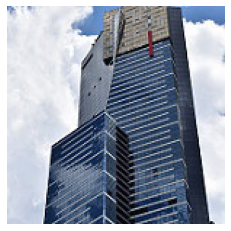

In [42]:
import imageio
import cv2

img = imageio.imread('/content/seg_test/seg_test/buildings/20057.jpg')
web_image = cv2.resize(img, dsize=(150, 150)).astype('float')
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)

prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)
print(prediction_idx)

print("Predicted class =", class_names[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(img)
plt.axis('off')
plt.show()